In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import contextily as cx
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


In [6]:
# Example: build a GeoDataFrame for nodes (EPSG:4326)
def build_nodes_gdf(nodes_df):
    gdf = gpd.GeoDataFrame(
        nodes_df.copy(),
        geometry=gpd.points_from_xy(nodes_df["lon"], nodes_df["lat"]),
        crs="EPSG:4326"
    )
    return gdf

In [7]:
df_nodes = pd.read_csv('data/final_merged_data_with_nighttimelights_08232025.csv')

In [8]:
df_nodes[['location_id', 'location_type', 'long', 'lat']]

,location_id,location_type,long,lat
0,102801000,municipality,120.919406,18.453391
1,102802000,municipality,120.612894,18.267248
2,102803000,municipality,120.509019,17.905964
3,102804000,municipality,120.749666,18.489743
4,102805000,municipality,120.584226,18.037747
...,...,...,...,...
1712,1903600000,province,124.336170,7.796692
1713,1906600000,province,121.054313,5.953179
1714,1907000000,province,119.900500,5.239282
1715,1908700000,province,124.243358,7.187669


In [9]:
df_ownership = pd.read_csv('data/ownership_edges.csv')
df_proximity = pd.read_csv('data/proximity_edges_all.csv')
df_features = pd.read_csv('data/feature_similarity_edges_fused.csv')


In [10]:
df_ownership.shape

(1642, 3)

In [11]:
df_proximity.shape

(28074, 3)

In [12]:
df_edges = pd.concat([df_ownership, df_proximity, df_features[['source', 'target', 'edge_type']].rename(columns={'edge_type': 'etype'})], ignore_index=True).rename(columns={'source': 'u', 'target': 'v', 'etype':'edge_type' })

In [13]:
df_edges['edge_type'].value_counts()

edge_type
proximity     28074
similarity    16252
ownership      1642
Name: count, dtype: int64

In [14]:
df_edges.to_csv('data/all_edges.csv', index=False)

In [15]:
def edges_to_geoms(edges_df, nodes_gdf, u_col="u", v_col="v"):
    # build a quick lookup: node_id -> Point geometry
    geom_map = nodes_gdf.set_index("node_id")["geometry"].to_dict()
    def make_line(row):
        pu, pv = geom_map.get(row[u_col]), geom_map.get(row[v_col])
        if pu is None or pv is None:
            return None
        return LineString([pu, pv])
    out = edges_df.copy()
    out["geometry"] = out.apply(make_line, axis=1)
    out = out[~out["geometry"].isna()]
    return gpd.GeoDataFrame(out, geometry="geometry", crs="EPSG:4326")

In [16]:
def plot_network_map(
    nodes_gdf: gpd.GeoDataFrame,
    edges_gdf: gpd.GeoDataFrame,
    node_type_col: str = "node_type",
    edge_type_col: str = "edge_type",
    node_size_map: dict | int = None,
    node_color_map: dict | str | None = None,
    edge_color_map: dict | str | None = None,
    edge_alpha: float = 0.8,
    edge_lw_map: dict | float = None,
    basemap_provider = cx.providers.OpenStreetMap.Mapnik,
    title: str = "Municipality Network (Philippines)",
    xlim=None, ylim=None,
    figsize=(10, 10),
):
    """
    Plot a multilayer/typed graph on an OSM basemap.

    nodes_gdf: GeoDataFrame with Point geometries, CRS=EPSG:4326 (WGS84).
               Must include a column `node_type_col` with 2 categories.
    edges_gdf: GeoDataFrame with LineString geometries, CRS=EPSG:4326.
               Must include a column `edge_type_col` with 3 categories.
    * _color_map args can be either:
        - dict mapping category -> color, or
        - a single color string applied to all.
    * _size/_lw maps can be dict category -> scalar or a single scalar.
    """

    assert nodes_gdf.crs and edges_gdf.crs, "Nodes/edges must have a CRS set (e.g., EPSG:4326)."

    # Defaults: 2 node types, 3 edge types
    node_types = sorted(nodes_gdf[node_type_col].dropna().unique().tolist())
    edge_types = sorted(edges_gdf[edge_type_col].dropna().unique().tolist())

    # Reasonable defaults if none provided
    if node_color_map is None:
        # pick distinct colors for 2 node types
        node_color_map = {t: c for t, c in zip(node_types, ["#1f77b4", "#ff7f0e"])}  # blue/orange
    elif isinstance(node_color_map, str):
        node_color_map = {t: node_color_map for t in node_types}

    if node_size_map is None:
        node_size_map = {t: 12 for t in node_types}  # points in matplotlib scatter

    if isinstance(node_size_map, (int, float)):
        node_size_map = {t: node_size_map for t in node_types}

    if edge_color_map is None:
        # 3 distinct colors for edges
        palette = ["#2ca02c", "#d62728", "#9467bd"]  # green/red/purple
        edge_color_map = {t: c for t, c in zip(edge_types, palette)}
    elif isinstance(edge_color_map, str):
        edge_color_map = {t: edge_color_map for t in edge_types}

    if edge_lw_map is None:
        edge_lw_map = {t: 1.2 for t in edge_types}
    if isinstance(edge_lw_map, (int, float)):
        edge_lw_map = {t: edge_lw_map for t in edge_types}

    # Reproject to Web Mercator for basemap
    nodes_3857 = nodes_gdf.to_crs(epsg=3857)
    edges_3857 = edges_gdf.to_crs(epsg=3857)

    # Figure & axes
    fig, ax = plt.subplots(figsize=figsize)

    # Optionally limit to PH extent (helps tile loading on wide datasets)
    if xlim and ylim:
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    else:
        # auto-bounds from data (with padding)
        try:
            total_bounds = gpd.GeoSeries(pd.concat([nodes_3857.geometry, edges_3857.geometry], ignore_index=True)).total_bounds
        except Exception:
            total_bounds = nodes_3857.total_bounds
        xmin, ymin, xmax, ymax = total_bounds
        dx, dy = xmax - xmin, ymax - ymin
        pad_x, pad_y = dx * 0.05, dy * 0.05
        ax.set_xlim(xmin - pad_x, xmax + pad_x)
        ax.set_ylim(ymin - pad_y, ymax + pad_y)

    # 1) Draw edges by type (under the nodes)
    for et in edge_types:
        sub = edges_3857[edges_3857[edge_type_col] == et]
        if len(sub) == 0: 
            continue
        sub.plot(
            ax=ax,
            linewidth=edge_lw_map.get(et, 1.0),
            alpha=edge_alpha,
            color=edge_color_map.get(et, "gray"),
        )

    # 2) Draw nodes by type (on top)
    for nt in node_types:
        sub = nodes_3857[nodes_3857[node_type_col] == nt]
        if len(sub) == 0: 
            continue
        sub.plot(
            ax=ax,
            markersize=node_size_map.get(nt, 10),
            color=node_color_map.get(nt, "gray"),
            alpha=0.95,
        )

    # Basemap last (zorder lower than nodes), but contextily adds under existing artists automatically
    cx.add_basemap(ax, source=basemap_provider, crs="EPSG:3857", attribution_size=6)

    # Build a combined legend (edges + nodes)
    edge_handles = [
        Line2D([0], [0], color=edge_color_map[et], lw=edge_lw_map.get(et, 1.0), label=f"Edge: {et}")
        for et in edge_types
    ]
    node_handles = [
        Patch(facecolor=node_color_map[nt], label=f"Node: {nt}")
        for nt in node_types
    ]

    ax.legend(handles=edge_handles + node_handles, loc="lower left", frameon=True)
    ax.set_axis_off()
    ax.set_title(title, fontsize=14)
    plt.tight_layout()
    plt.show()


In [17]:
df_nodes[['location_id', 'location_type', 'long', 'lat']].rename(columns={'long': 'long'})

,location_id,location_type,long,lat
0,102801000,municipality,120.919406,18.453391
1,102802000,municipality,120.612894,18.267248
2,102803000,municipality,120.509019,17.905964
3,102804000,municipality,120.749666,18.489743
4,102805000,municipality,120.584226,18.037747
...,...,...,...,...
1712,1903600000,province,124.336170,7.796692
1713,1906600000,province,121.054313,5.953179
1714,1907000000,province,119.900500,5.239282
1715,1908700000,province,124.243358,7.187669


In [18]:
df_nodes

,region_code,region,province,location_id,location_type,location_name,long,lat,population_2024,population_2024_mask,...,ntl_sum,px_count,ntl_p10,ntl_p90,bright_frac,moderate_frac,dark_frac,ntl_gini,ntl_skew,ntl_kurtosis
0,100000000,Region I (Ilocos Region),Ilocos Norte,102801000,municipality,Adams,120.919406,18.453391,2279.0,1,...,115.830000,485.0,0.140,0.330,0.000000,0.000000,1.000000,0.189877,0.801555,-3.005303
1,100000000,Region I (Ilocos Region),Ilocos Norte,102802000,municipality,Bacarra,120.612894,18.267248,32734.0,1,...,319.610000,240.0,0.529,2.380,0.000000,0.466667,0.533333,0.405770,3.323437,-2.974038
2,100000000,Region I (Ilocos Region),Ilocos Norte,102803000,municipality,Badoc,120.509019,17.905964,32832.0,1,...,231.770000,355.0,0.250,1.106,0.000000,0.107042,0.892958,0.430498,5.953050,-2.883981
3,100000000,Region I (Ilocos Region),Ilocos Norte,102804000,municipality,Bangui,120.749666,18.489743,15227.0,1,...,244.880000,526.0,0.200,0.840,0.000000,0.085551,0.914449,0.405439,4.425596,-2.966899
4,100000000,Region I (Ilocos Region),Ilocos Norte,102805000,municipality,City of Batac,120.584226,18.037747,56781.0,1,...,677.379997,693.0,0.270,1.278,0.010101,0.139971,0.849928,0.561493,10.053347,-2.837576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,1900000000,Bangsamoro Autonomous Region In Muslim Mindana...,lanao del sur,1903600000,province,lanao del sur,124.336170,7.796692,1261573.0,1,...,5801.270003,15833.0,0.220,0.480,0.000000,0.019137,0.980863,0.233070,9.489714,-2.989952
1713,1900000000,Bangsamoro Autonomous Region In Muslim Mindana...,sulu,1906600000,province,sulu,121.054313,5.953179,1146097.0,1,...,2345.260002,8373.0,0.180,0.360,0.000000,0.007644,0.992356,0.202470,12.858485,-2.973666
1714,1900000000,Bangsamoro Autonomous Region In Muslim Mindana...,tawi-tawi,1907000000,province,tawi-tawi,119.900500,5.239282,482645.0,1,...,1741.990000,5531.0,0.180,0.390,0.000000,0.015549,0.984451,0.254276,13.386185,-2.959374
1715,1900000000,Bangsamoro Autonomous Region In Muslim Mindana...,maguindanao del norte,1908700000,province,maguindanao del norte,124.243358,7.187669,1124811.0,1,...,3663.840004,8784.0,0.240,0.530,0.000683,0.026412,0.972905,0.299196,14.342618,-2.966467


In [19]:
df_nodes.to_csv('data/all_nodes.csv', index=False)

In [20]:
nodes_gdf = build_nodes_gdf(df_nodes[['location_id', 'location_type', 'long', 'lat']].rename(columns={'location_id':'node_id', 'long': 'lon', 'location_type': 'node_type'}))

In [21]:
nodes_gdf

,node_id,node_type,lon,lat,geometry
0,102801000,municipality,120.919406,18.453391,POINT (120.91941 18.45339)
1,102802000,municipality,120.612894,18.267248,POINT (120.61289 18.26725)
2,102803000,municipality,120.509019,17.905964,POINT (120.50902 17.90596)
3,102804000,municipality,120.749666,18.489743,POINT (120.74967 18.48974)
4,102805000,municipality,120.584226,18.037747,POINT (120.58423 18.03775)
...,...,...,...,...,...
1712,1903600000,province,124.336170,7.796692,POINT (124.33617 7.79669)
1713,1906600000,province,121.054313,5.953179,POINT (121.05431 5.95318)
1714,1907000000,province,119.900500,5.239282,POINT (119.9005 5.23928)
1715,1908700000,province,124.243358,7.187669,POINT (124.24336 7.18767)


In [22]:
edges_gdf = edges_to_geoms(df_edges, nodes_gdf)

In [23]:
edges_gdf

,u,v,edge_type,geometry
0,102800000,102801000,ownership,"LINESTRING (120.73012 18.20481, 120.91941 18.4..."
1,102800000,102802000,ownership,"LINESTRING (120.73012 18.20481, 120.61289 18.2..."
2,102800000,102803000,ownership,"LINESTRING (120.73012 18.20481, 120.50902 17.9..."
3,102800000,102804000,ownership,"LINESTRING (120.73012 18.20481, 120.74967 18.4..."
4,102800000,102805000,ownership,"LINESTRING (120.73012 18.20481, 120.58423 18.0..."
...,...,...,...,...
45963,201518000,990101000,similarity,"LINESTRING (121.32782 18.44498, 121.98685 6.65..."
45964,990101000,1705324000,similarity,"LINESTRING (121.98685 6.65059, 118.01479 9.06483)"
45965,105532000,1430300000,similarity,"LINESTRING (120.32792 15.90797, 120.59617 16.3..."
45966,305409000,1430300000,similarity,"LINESTRING (120.55511 15.21703, 120.59617 16.3..."


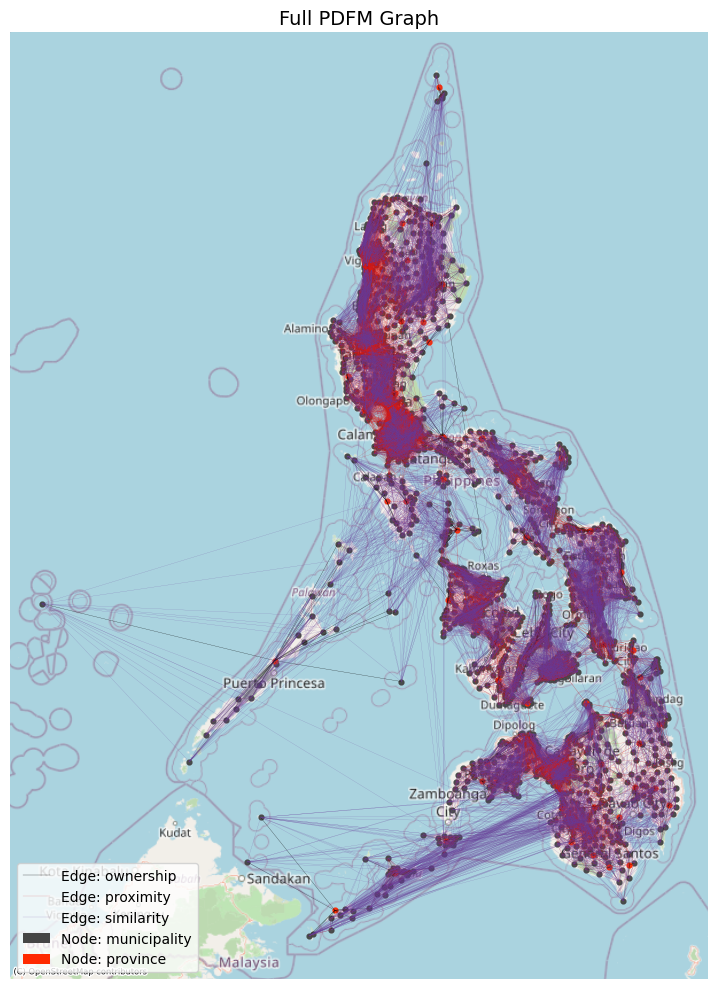

In [24]:
plot_network_map(
    nodes_gdf,
    edges_gdf,
    node_type_col="node_type",
    edge_type_col="edge_type",
    # Custom palettes (optional)
    node_color_map={"municipality": "#454545", "province": "#ff2a00"},
    edge_color_map={"ownership": "#000000", "proximity": "#d61919", "similarity": "#6a3d9a"},
    edge_lw_map={"ownership": 0.2, "proximity": 0.1, "similarity": 0.1},
    title="Full PDFM Graph"
)

# Export nodes file for visualization

In [25]:
df_nodes_raw_features = pd.read_csv('data/raw_features_wlights.csv')

In [26]:
df_nodes_raw_features.shape

(1717, 475)

In [27]:
df_nodes_raw_features.columns.tolist()

['region_code',
 'region',
 'province',
 'location_id',
 'location_type',
 'location_name',
 'long',
 'lat',
 'population_2024',
 'population_2024_mask',
 'count_711',
 'mercury_count',
 'watsons_total_count',
 'shop',
 'restaurant',
 'school',
 'bank',
 'fast_food',
 'place_of_worship',
 'fuel',
 'pharmacy',
 'cafe',
 'parking',
 'townhall',
 'bar',
 'police',
 'atm',
 'community_centre',
 'bus_station',
 'clinic',
 'sport',
 'shelter',
 'toilets',
 'hospital',
 'post_office',
 'bench',
 'public_building',
 'college',
 'marketplace',
 'kindergarten',
 'fire_station',
 'dentist',
 'car_wash',
 'temp_min',
 'temp_max',
 'temp_avg',
 'temp_median',
 'temp_p25',
 'temp_p75',
 'temp_std',
 'humidity_min',
 'humidity_max',
 'humidity_avg',
 'humidity_median',
 'humidity_p25',
 'humidity_p75',
 'humidity_std',
 'precipitation_avg',
 'precipitation_p75',
 'precipitation_std',
 'wind_min',
 'wind_max',
 'wind_avg',
 'wind_median',
 'wind_p25',
 'wind_p75',
 'wind_std',
 'pressure_min',
 'press

In [28]:
df_dmn_tiers_municipality = pd.read_csv('data/municipality_tiers.csv')
df_dmn_tiers_province = pd.read_csv('data/province_tiers.csv')

In [29]:
df_dmn_tiers_province

,location_id,tier,province_tier_weight
0,102800000,Tier 4,0.523292
1,102900000,Tier 3,1.000000
2,103300000,Tier 3,0.512847
3,105500000,Tier 3,0.707171
4,200900000,Tier 4,1.000000
...,...,...,...
78,1903600000,Tier 4,1.000000
79,1906600000,Tier 4,1.000000
80,1907000000,Tier 4,1.000000
81,1908700000,Tier 4,0.659158


In [30]:
df_tiers = pd.concat([df_dmn_tiers_municipality, df_dmn_tiers_province[['location_id', 'tier']]], axis=0)

In [31]:
df_tiers

,location_id,tier
0,102801000,Tier 4
1,102802000,Tier 4
2,102803000,Tier 2
3,102804000,Tier 4
4,102805000,Tier 2
...,...,...
78,1903600000,Tier 4
79,1906600000,Tier 4
80,1907000000,Tier 4
81,1908700000,Tier 4


In [ ]:
group_spec = {
    'node_info' : [
        'region_code',
        'region',
        'province',
        'location_id',
        'location_type',
        'location_name',
        'long',
        'lat',
        'tier',
        'population_2024'
    ],
    'pois': [
        'count_711',
        'mercury_count',
        'watsons_total_count'
    ],
    'amen'   : [
        'shop','restaurant','school','bank','fast_food','place_of_worship','fuel','pharmacy','cafe','parking','townhall','bar','police','atm','community_centre','bus_station','clinic','sport','shelter','toilets','hospital','post_office','bench','public_building','college','marketplace','kindergarten','fire_station','dentist','car_wash',
        'amenity_count','amenity_density_scaled','amenity_proximity_scaled','amenity_entropy_scaled','amenity_equity_scaled'
            ], 
    'airw'   : [
        'temp_min','temp_max','temp_avg','temp_median','temp_p25','temp_p75','temp_std','humidity_min','humidity_max','humidity_avg','humidity_median','humidity_p25','humidity_p75','humidity_std','precipitation_avg','precipitation_p75','precipitation_std','wind_min','wind_max','wind_avg','wind_median','wind_p25','wind_p75','wind_std','pressure_min','pressure_max','pressure_avg','pressure_median','pressure_p25','pressure_p75','pressure_std','clouds_avg','clouds_median','clouds_p25','clouds_p75','clouds_std','aqi_july_mean','pm2_5_july_mean','pm10_july_mean','no_july_mean','no2_july_mean','so2_july_mean','co_july_mean','o3_july_mean','nh3_july_mean'
            ],
    'search' : [
        '10','10.0.0.0.1','10.0.0.1','ai','anime','calculator','canva','chat','chat gpt','chatgpt','download','drawing','english tagalog','english to tagalog','face','facebook','fb','gmail','google','google translate','gpt','gpt chat','grow a garden','lotto result','map','messenger','movies','now','pag ibig','pinay','piso wifi','poster','reddit','result today','roblox','scandal','sias','sss','swertres','swertres result','swertres result today','tagalog english','tagalog to english','test','the','tiktok','time','time now','translate','translate english to tagalog','translate tagalog to english','translate to english','translate to tagalog','usd to php','videos','weather','weather tomorrow','wifi','wifi pause','you','youtube'
            ],
    'busy'   : [
        'vAg Clustering','Degree Centrality','Group Closeness Centrality', 'ntl_mean', 'ntl_median', 'ntl_min', 'ntl_max', 'ntl_std', 'ntl_sum', 'px_count', 'ntl_p10', 'ntl_p90', 'bright_frac', 'moderate_frac', 'dark_frac', 'ntl_gini', 'ntl_skew', 'ntl_kurtosis'
        ]
}

In [33]:
all_raw_features = [item for sublist in group_spec.values() for item in sublist]

In [34]:
all_raw_features

['region_code',
 'region',
 'province',
 'location_id',
 'location_type',
 'location_name',
 'long',
 'lat',
 'tier',
 'population_2024',
 'count_711',
 'mercury_count',
 'watsons_total_count',
 'shop',
 'restaurant',
 'school',
 'bank',
 'fast_food',
 'place_of_worship',
 'fuel',
 'pharmacy',
 'cafe',
 'parking',
 'townhall',
 'bar',
 'police',
 'atm',
 'community_centre',
 'bus_station',
 'clinic',
 'sport',
 'shelter',
 'toilets',
 'hospital',
 'post_office',
 'bench',
 'public_building',
 'college',
 'marketplace',
 'kindergarten',
 'fire_station',
 'dentist',
 'car_wash',
 'amenity_count',
 'amenity_density_scaled',
 'amenity_proximity_scaled',
 'amenity_entropy_scaled',
 'amenity_equity_scaled',
 'temp_min',
 'temp_max',
 'temp_avg',
 'temp_median',
 'temp_p25',
 'temp_p75',
 'temp_std',
 'humidity_min',
 'humidity_max',
 'humidity_avg',
 'humidity_median',
 'humidity_p25',
 'humidity_p75',
 'humidity_std',
 'precipitation_avg',
 'precipitation_p75',
 'precipitation_std',
 'wind_

In [35]:
df_all = pd.merge(df_nodes_raw_features, df_tiers, on='location_id', how='left')

In [36]:
df_all[all_raw_features].to_csv('data/all_node_features.csv', index=False)

In [37]:
df_all

,region_code,region,province,location_id,location_type,location_name,long,lat,population_2024,population_2024_mask,...,px_count,ntl_p10,ntl_p90,bright_frac,moderate_frac,dark_frac,ntl_gini,ntl_skew,ntl_kurtosis,tier
0,100000000,Region I (Ilocos Region),Ilocos Norte,102801000,municipality,Adams,120.919406,18.453391,2279.0,1,...,485.0,0.140,0.330,0.000000,0.000000,1.000000,0.189877,0.801555,-3.005303,Tier 4
1,100000000,Region I (Ilocos Region),Ilocos Norte,102802000,municipality,Bacarra,120.612894,18.267248,32734.0,1,...,240.0,0.529,2.380,0.000000,0.466667,0.533333,0.405770,3.323437,-2.974038,Tier 4
2,100000000,Region I (Ilocos Region),Ilocos Norte,102803000,municipality,Badoc,120.509019,17.905964,32832.0,1,...,355.0,0.250,1.106,0.000000,0.107042,0.892958,0.430498,5.953050,-2.883981,Tier 2
3,100000000,Region I (Ilocos Region),Ilocos Norte,102804000,municipality,Bangui,120.749666,18.489743,15227.0,1,...,526.0,0.200,0.840,0.000000,0.085551,0.914449,0.405439,4.425596,-2.966899,Tier 4
4,100000000,Region I (Ilocos Region),Ilocos Norte,102805000,municipality,City of Batac,120.584226,18.037747,56781.0,1,...,693.0,0.270,1.278,0.010101,0.139971,0.849928,0.561493,10.053347,-2.837576,Tier 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,1900000000,Bangsamoro Autonomous Region In Muslim Mindana...,lanao del sur,1903600000,province,lanao del sur,124.336170,7.796692,1261573.0,1,...,15833.0,0.220,0.480,0.000000,0.019137,0.980863,0.233070,9.489714,-2.989952,Tier 4
1713,1900000000,Bangsamoro Autonomous Region In Muslim Mindana...,sulu,1906600000,province,sulu,121.054313,5.953179,1146097.0,1,...,8373.0,0.180,0.360,0.000000,0.007644,0.992356,0.202470,12.858485,-2.973666,Tier 4
1714,1900000000,Bangsamoro Autonomous Region In Muslim Mindana...,tawi-tawi,1907000000,province,tawi-tawi,119.900500,5.239282,482645.0,1,...,5531.0,0.180,0.390,0.000000,0.015549,0.984451,0.254276,13.386185,-2.959374,Tier 4
1715,1900000000,Bangsamoro Autonomous Region In Muslim Mindana...,maguindanao del norte,1908700000,province,maguindanao del norte,124.243358,7.187669,1124811.0,1,...,8784.0,0.240,0.530,0.000683,0.026412,0.972905,0.299196,14.342618,-2.966467,Tier 4


In [39]:
df_all['location_name'] = df_all['location_name'].str.title()

In [41]:
df_all.to_csv('data/all_nodes_withtier.csv', index=False)